<a href="https://colab.research.google.com/github/Olivia-Feldman/Cifar10_CNN_-Classification/blob/main/Cifar10_nn_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
valid_ratio = 0.3

In [ ]:
#transforming the data to get better accuracy results - Data augmentation 
#https://pytorch.org/docs/stable/torchvision/transforms.html
# My method is to use rotations and flip to get ride of irrelevant data 

transform_train = transforms.Compose([
                           
    transforms.RandomCrop(32, padding=4), # extracting a patch of size 32 randomly 
    transforms.RandomHorizontalFlip(), # horizontal flip of image 
    #transforms.RandomRotation(90), # random rotation of 90 degrees 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalizing the data 
])

# Normalize the test set 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# plotting some image 
import matplotlib.pyplot as plt
import numpy as np

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']



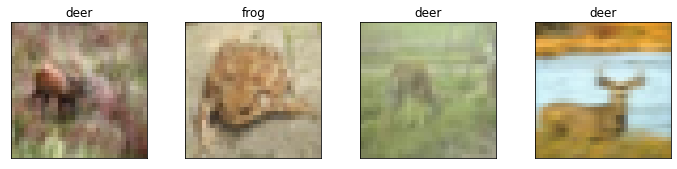

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [ ]:
import torch
import torch.nn as nn

class net(nn.Module): 
    def __init__(self): 
        super().__init__()
        # first convolutional layer, 
          # 3 = color channels 
          # 6 = number of output channels 
          # 5 = kernel size. This x the input matrix will be the output matrix 
          # and size of scope we use to iteratie throuhg image matrix ( 5x5)  
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pool layer finds the max values from the batch of the feature map 
        self.pool = nn.MaxPool2d(2,2)
        # second convoultional layer 
        self.conv2 = nn.Conv2d(6,16,5) 
        self.fc1 = nn.Linear(16*5*5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #reduces dimension back down and the outputs match # of lables 
        
    def forward(self, x): 
      
        # using relu activation function to determine what inputs are fired 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation on final layer 
        return x






In [ ]:
net = net()
print(sum([p.numel() for p in net.parameters()]))

62006


In [ ]:

import torch.optim as optim
# chossing a SGD as my optimzer at a learning rate of .001 which is the common default for this value 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cpu


net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# mounting the google drive 
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/data/cifar10'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

epochs = 15

# keeping track of loss and 
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []



# iterating through epochs training cycle 
for e in range(epochs): 
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    
    outputs = net(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 
    
    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.
    
    _, preds = torch.max(outputs, 1) #finding highest value of prediction 
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in testloader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss/len(trainloader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    # implementing Early stopping so model will not overfit the data 
    if val_running_loss >epoch_loss: # stop iterating when 
      running_loss_history.append(epoch_loss) 
      running_corrects_history.append(epoch_acc)
    
      val_epoch_loss = val_running_loss/len(testloader)
      val_epoch_acc = val_running_corrects.float()/ len(testloader)

      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    else: 
      print('early stopping')
      break 

epoch : 1
training loss: 1.7112, acc 1.4719 
validation loss: 1.4975, validation acc 1.8700 
epoch : 2
training loss: 1.3539, acc 2.0651 
validation loss: 1.2634, validation acc 2.2120 
epoch : 3
training loss: 1.2162, acc 2.2686 
validation loss: 1.1789, validation acc 2.3108 
epoch : 4
training loss: 1.1159, acc 2.4249 
validation loss: 1.1701, validation acc 2.3652 
epoch : 5
training loss: 1.0456, acc 2.5238 
validation loss: 1.1397, validation acc 2.4032 
epoch : 6
training loss: 0.9863, acc 2.6069 
validation loss: 1.1553, validation acc 2.4228 
epoch : 7
training loss: 0.9384, acc 2.6734 
validation loss: 1.1016, validation acc 2.4820 
epoch : 8
training loss: 0.8999, acc 2.7240 
validation loss: 1.0829, validation acc 2.5212 
epoch : 9
training loss: 0.8684, acc 2.7754 
validation loss: 1.1431, validation acc 2.4596 
epoch : 10
training loss: 0.8327, acc 2.8199 
validation loss: 1.1586, validation acc 2.4788 
epoch : 11
training loss: 0.8062, acc 2.8534 
validation loss: 1.1468

In [ ]:
torch.save(net.state_dict(), PATH)

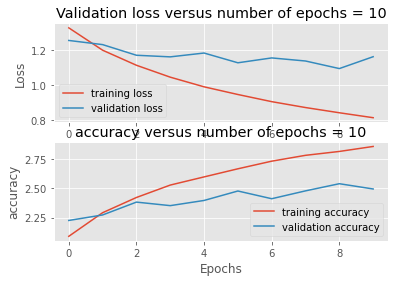

In [ ]:
# looking at 10 epochs and no data augmentation 
plt.subplot(2,1,1)
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.title('Validation loss versus number of epochs = 10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2,1,2)
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.title('accuracy versus number of epochs = 10')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# as we can see the accuracy is still rising and the model is underfitting the data in loss versus spochs graph 
# instead of ten. More training time is needed on the data 
# 'Accuracy of the network on the 10000 test images: 62% 

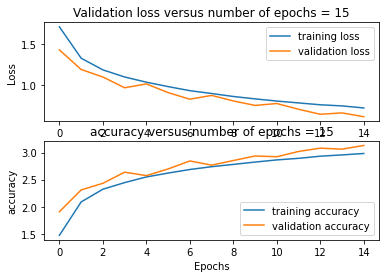

In [ ]:
# looking at 15 epochs with data augmentaion 

plt.subplot(2,1,1)
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.title('Validation loss versus number of epochs = 15')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2,1,2)
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.title('accuracy versus number of epochs = 15')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# the more training time has given us better accuracy but still underfitting 

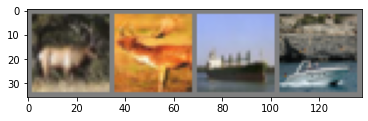

Test labels:   deer  deer  ship  ship
Predicted:   frog  deer  frog   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
dataiter = iter(testloader)
images, labels = dataiter.next()

#This method shows some test images 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
# prints the actual test label 
print('Test labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs, 1)
#prints the predicted classificatoin 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:

# looking at the accuracy of the network 

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 78 %
